# NLVR2 Visual Bias Analysis
**[Alane Suhr](http://alanesuhr.com/) and [Yoav Artzi](https://yoavartzi.com), Cornell University**

[NLVR2](http://lil.nlp.cornell.edu/nlvr/) (Suhr et al. 2019) was designed to be robust for language bias through a data collection process that resulted in each natural language sentence appearing with both true and false labels. The process did not provide a similar measure of control for visual bias. This note analyzes the potential for visual bias in NLVR2. We show that some amount of visual bias likely exists. Finally, we identify a subset of the test data that allows to test for model performance in a way that is robust to such potential biases. We show that the performance of existing models (Li et al. 2019; Tan and Bansal 2019) is relatively robust to this potential bias. We propose to add the evaluation on this subset of the data to the NLVR2 evaluation protocol, and update the official release to include it. This note incldues the code required to replicate the analysis to encourage further analysis of the data. 

In [1]:
import io
import json
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter, namedtuple
from IPython.display import Image
from IPython.core.display import HTML 
from prettytable import PrettyTable

In [2]:
train_data = list(map(json.loads, open('train.json').readlines()))
dev_data = list(map(json.loads, open('dev.json').readlines()))

## Introduction

NLVR (Suhr et al. 2017) proposes a simple binary classification task: given an image and a natural language statement, predict if the statement is `true` or `false` with regard to the image. The images in NLVR are syntehtically generated, and the language was collected through a crowdsourcing process. The image generation and data collection process was designed to generate data robust to single-modality biases. Each statement is paired with multiple images, some pairings have the label `true`, while others are `false`. The images were generated so for each image that is in an example with the label `true`, there is an image with exactly the same set of objects but arranged differently in an example with the same sentence, but with the label `false`. Below are four examples from NLVR, all using the same statement. 

In [3]:
print("There is a yellow block as the top of a tower with exactly three blocks.")

display(Image(url="https://raw.githubusercontent.com/clic-lab/nlvr/master/nlvr/dev/images/5/dev-3520-1-0.png", width=400))
print("True")

display(Image(url="https://raw.githubusercontent.com/clic-lab/nlvr/master/nlvr/dev/images/5/dev-3520-2-1.png", width=400))
print("False")

display(Image(url="https://raw.githubusercontent.com/clic-lab/nlvr/master/nlvr/dev/images/5/dev-3520-0-2.png", width=400))
print("True")

display(Image(url="https://raw.githubusercontent.com/clic-lab/nlvr/master/nlvr/dev/images/5/dev-3520-3-2.png", width=400))
print("False")


There is a yellow block as the top of a tower with exactly three blocks.


True


False


True


False


NLVR2 is a similar binary classification task. Given two paired images and a natural language statement, the goal is to decide if the statement is `true` or `false` with the regard to the pair of images. The NLVR2 data collection process included creating a new set of web images and a compare and contrast sentence-writing task, which enabled collecting semantically diverse natural language. 

**Overview of the Data Collection Process** The data collection process is split into: (a) collecting sets of image pairs, (b) setntence writing, and (c) validation. In the first step, sets of eight related images are collected and randomly split into four pairs. Each set of four pairs is given to a worker. They were asked to select two pairs, and write a sentence that is `true` for the selected pairs and `false` for the other pairs. Finally, workers are presented with an image pair and a statement to validate the label assigned by the sentence writer. This leads to pruning a small part of the data, so not all statements appear exactly four times (i.e., with the four orignal image pairs). Below is an example statement from NLVR2 that is paired with four image pairs, two with a label of `true` and two with `false`.  

In [4]:
acorn_id = "train-9952"
acorn_examples = list()
for example in train_data:
    if example["identifier"].startswith(acorn_id) and example["identifier"][-1] == '1':
        acorn_examples.append(example)

print(acorn_examples[0]["sentence"] + "\n")

for i, example in enumerate(sorted(acorn_examples, key = lambda x: x["identifier"])):
    print(example["identifier"])
    image = Image(url="https://raw.githubusercontent.com/lil-lab/nlvr/master/nlvr2/ipynb_data/pair_%d.png" % i, width=400)
    display(image)
    print(example["label"] + "\n")

One image shows exactly two brown acorns in back-to-back caps on green foliage.

train-9952-0-1


True

train-9952-1-1


False

train-9952-2-1


True

train-9952-3-1


False



## Bias in NLVR2

**Robustness to Language Bias** Each sentence is written to be `true` for two pairs of images and `false` for two pairs. This way, each sentence appears with multiple image pairs with different labels (unless some were pruned in validation). This provides robustness against languasge biases (i.e., some sentences are more likely to be `true` or `false` depending on the langauge).

**Why would visual bias occur?** It is possible that some image pairs are more likely to be picked so that the sentence written for them has the label `true` and some are more likely to elicit the label `false` based on the visual content alone. This can lead to models that use this bias to solve the task while ignoring the natural language statement. This may happen because it was left to the workers to pick which pairs to label as `true` and `false`. This was done to the workers to make the task easier. Suhr et al. 2019 note that forcing the label assignment creates a much harder task of what is already a challenging annotation task. 

**How can we measure visual bias?** During the annotation process, pairs of images are often annotated multiple times, and appear in the data with different sentences. The majority of such cases is because each set of pairs was annotated twice to obtain more natural language data with the available of sets of image pairs. However, a small number of pairs were annotated even more times because they appeared in multiple sets (i.e., set of four pairs). This happened by chance, and relatively rarely. 

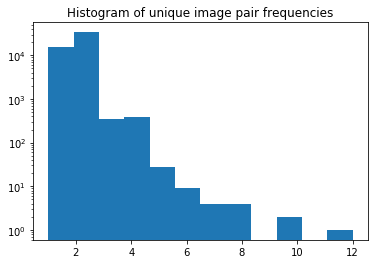

In [5]:
pair_labels = dict()
for x in train_data:
    pair = x['left_url'], x['right_url']
    if pair not in pair_labels:
        pair_labels[pair] = list()
    pair_labels[pair].append((x['identifier'], x['label']))
    
plt.hist([len(val) for val in pair_labels.values()], bins=12, log=True)
plt.title('Histogram of unique image pair frequencies')
plt.show()

As expected, the majority of pairs that appear multiple times appear twice. This is because each set of image pairs was annotated with a natural language sentence twice. If labels are assigned randomly by the sentence writers, we would expect about half of these pairs to have exactly the same label in both instances (`true`/`true` or `false`/`false`).

In [6]:
num_pairs_occurring_twice = len([pair for pair, labels in pair_labels.items() if len(labels) == 2])
print('There are {} pairs that occur twice, so we expect roughly {} pairs to have the same label in both instances.'.format(num_pairs_occurring_twice, 
                                                                                                                            num_pairs_occurring_twice / 2))

There are 33866 pairs that occur twice, so we expect roughly 16933.0 pairs to have the same label in both instances.


However, the observed frequency of pairs with the same label is higher:

In [7]:
len([pair for pair, labels in pair_labels.items() if len(labels) == 2 and len(set([item[1] for item in labels])) == 1])

21267

The pairs that occur twice likely appeared along with the same images during sentence-writing. Workers were prompted to write a sentence true about the selected pairs and false about the unselected pairs, and therefore are likely to prefer to select the two pairs that are more similar to each other within the set of four pairs. This could explain a bias towards a certain label for that pair. One explanation of this observation is that the bias exists when considering each image pair in the context of the other pairs it appeared with in sentence-writing. When taken out of this context, as in the NLVR2 task, this bias may become irrelelvant. 

Pairs that occur more than twice in the data are more interesting. Consider an event that is less likely: pairs that occur three times with the same label. The probability for a pair to have the same label (`true`/`true`/`true` or `false`/`false`/`false`) is 0.25.

In [8]:
num_pairs_occurring_thrice = len([pair for pair, labels in pair_labels.items() if len(labels) == 3])
print('There are {} image pairs that appear three times in the data.'.format(num_pairs_occurring_thrice))
print('We expect {} of these pairs to have the same label in all instances.'.format(num_pairs_occurring_thrice / 8))
print('We observe empirically that {} of these pairs have exactly the same label across all instances.'.format(len([pair for pair, labels in pair_labels.items() if len(labels) == 3 and len(set([item[1] for item in labels])) == 1])))

There are 345 image pairs that appear three times in the data.
We expect 43.125 of these pairs to have the same label in all instances.
We observe empirically that 128 of these pairs have exactly the same label across all instances.


We can generalize this analysis to all observed pair frequencies in the training data:

In [9]:
freq_tab = PrettyTable()

freq_tab.field_names = ['Pair frequency', '# pairs', 'Expected # same', 'Expected prop. same', 'Observed # same', 'Proportion observed same']

for i in range(2, max([len(labels) for labels in pair_labels.values()])):
    num_occurring_i = len([pair for pair, labels in pair_labels.items() if len(labels) == i])
    if num_occurring_i > 0:
        expected_prop_same = 2 / math.pow(2, i)
        expected_same = num_occurring_i * expected_prop_same
        observed_same = len([pair for pair, labels in pair_labels.items() if len(labels) == i and len(set([item[1] for item in labels])) == 1])
        freq_tab.add_row([i, 
                          num_occurring_i, 
                          '{0:.2f}'.format(expected_same), 
                          '{0:.2f}'.format(100. * expected_prop_same), 
                          observed_same, 
                          '{0:.2f}'.format(100. * observed_same / num_occurring_i)])
print(freq_tab)

+----------------+---------+-----------------+---------------------+-----------------+--------------------------+
| Pair frequency | # pairs | Expected # same | Expected prop. same | Observed # same | Proportion observed same |
+----------------+---------+-----------------+---------------------+-----------------+--------------------------+
|       2        |  33866  |     16933.00    |        50.00        |      21267      |          62.80           |
|       3        |   345   |      86.25      |        25.00        |       128       |          37.10           |
|       4        |   377   |      47.12      |        12.50        |       103       |          27.32           |
|       5        |    28   |       1.75      |         6.25        |        5        |          17.86           |
|       6        |    9    |       0.28      |         3.12        |        1        |          11.11           |
|       7        |    4    |       0.06      |         1.56        |        0        |  

We see that identical labeling appears at a proportion (proportion observed same) much more than expected if assuming labeling events are independent (expected prop. same). Below we show a few examples of pairs that appear many times with the same label, along with the label they were given and the sentences they are paired with:

In [10]:
for i in range(5):
    image = Image(url="https://raw.githubusercontent.com/lil-lab/nlvr/master/nlvr2/ipynb_data/pairex%d.png" % i, width=400)
    display(image)

**What does that mean for performance?** If the bias is real, we can try to compute what would a model that perfectly learns the bias but ignores the langauge will perform. This is a worst case scenario, and assumes we can perfectly learn the bias on the evaluation set. We assume that for all image pairs in the evaluation set, the model outputs the majority label for this pair for all examples including this pair. For image pairs that appear once, the model outputs the gold label. If a pair appears twice with the label `true`, the model outputs `true` for both examples. If a pair appears in three examples with `true`, `false`, and `true`, the model outputs `true`, and gets two out of the three right. We break ties with `true`, which is the majority class in the data. We compute this on the development set. 

In [11]:
pair_labels = dict()
for x in dev_data:
    pair = x['left_url'], x['right_url']
    if pair not in pair_labels:
        pair_labels[pair] = list()
    pair_labels[pair].append((x['identifier'], x['label']))
    
predictions = dict()
for pair, labels in pair_labels.items():
    num_true = len([label for label in labels if label[1].lower() == 'true'])
    num_false = len(labels) - num_true
    
    label = 'true' if num_true >= num_false else 'false'
    
    for identifier, true_label in labels:
        predictions[identifier] = label

print('Labeled %d examples' % len(predictions))

# Compute the accuracy
correct = list()
for example in dev_data:
    correct.append(predictions[example["identifier"]].lower() == example["label"].lower())

print('Accuracy: ' + '{0:.2f}'.format(100. * np.mean(np.array(correct))) + '%')
    

Labeled 6982 examples
Accuracy: 83.53%


## New Evaluation Protocol

**Can we find a way to evaluate the data that is robust to this visual bias?** We can isolate the part of the evaluation set that is clearly not susceptible to visual bias and test on it. If models perform on it as well as they do on the general evaluation set, they are not taking advantage of the bias. We identify all image pairs that appear in the evaluation data multiple times but with different labels (*balanced labels*). Because the evalaution sets are much smaller, the highest frequency of pairs is two. We create new evaluation sets where each image pair appears twice, once with the label `true` and once with `false`. The new sets are smaller, but still large enough to evaluate. We only report accuracy on this subset of the data because consistency changes due to the example selection process and we wish to avoid confusion with the consistency measures of the existing splits. Similarly, we evaluate on the subset of the data consisting of pairs that appear more than once with the same label (*unbalanced labels*).

In [12]:
balanced_ids = list()
unbalanced_ids = list()
for urls, examples in pair_labels.items():
    if len(examples) > 1:
        if len(set([item[1] for item in examples])) > 1:
            for item in examples:
                balanced_ids.append(item)
        else:
            for item in examples:
                unbalanced_ids.append(item)

print('Balanced examples: ' + str(len(balanced_ids)) + ' examples out of ' + str(len(predictions)))
print('Unbalanced examples: ' + str(len(unbalanced_ids)) + ' examples out of ' + str(len(predictions)))

Balanced examples: 2300 examples out of 6982
Unbalanced examples: 3562 examples out of 6982


**Do SOTA models take advantage of the potential visual bias we identify?** The answer is mostly "no". We evaluate the models of Li et al. 2019 and Tan and Bansal 2019 using the subset of the evaluation data and show that they largely maintain their reported performance, although there is a small drop in performance on the balanced set and a small increase in performance on the unbalanced set. For each system, we report the accuracy on the complete split and the accuracy on the new subset of the split (`original split / balanced subset / unbalanced`). We also report in parenthesis the delta to the accuracy on the original evaluation set. 

| Split       	| System              	| Original 	| Balanced   	| Unbalanced 	|
|-------------	|---------------------	|----------	|------------	|------------	|
| Development 	| Li et al. 2019      	| 67.4     	| 66.0(-1.4) 	| 69.1(+1.7) 	|
| Development 	| Tan and Bansal 2019 	| 74.9     	| 74.0(-0.9) 	| 76.4(+1.5) 	|
| Test-P      	| Li et al. 2019      	| 67.0     	| 65.7(-1.3) 	| 68.6(+1.6) 	|
| Test-P      	| Tan and Bansal 2019 	| 74.5     	| 73.1(-1.4) 	| 76.0(+1.5) 	|
| Test-U      	| Li et al. 2019      	| 67.3     	| 67.3(+0.0) 	| 68.2(+0.9) 	|
| Test-U      	| Tan and Bansal 2019 	| 76.2     	| 76.6(+0.4) 	| 76.5(+0.3) 	|

## Conclusion

We study the potential for visual bias in NLVR2, and show that allowing the workers to assign labels to image pairs may have introduced some level of visual bias. We quantify this potential bias, and calculate the best possible performance for a model relying on this bias. We also create new evaluation sets using subset of the original evaluation data. These new sets are robust to bias, and provide an avenue to test if models are taking advantage of latent bias. Our evaluation of existing SOTA models using the new evaluation sets shows that largely they do not take advantage of latent visual bias and confirm their impressive gains. 

The key takeaway is the addition of the new evaluation sets for NLVR2 evaluation. We add these evaluation sets to the NLVR2 data release. We also recommend evaluating exsiting models on the original NLVR corpus, which includes synthetic images, and was constructed to be robust to both visual and lingusitic biases. However, this may be challenging for models relying on pre-training using natural images. 

## References

Liunian Harold Li, Mark Yatskar, Da Yin, Cho-Jui Hsieh, and Kai-Wei Chang. 2019. [VisualBERT: A simple and performant baseline for vision and language](https://arxiv.org/abs/1908.03557). *CoRR*, abs/1908.03557.

Alane Suhr, Mike Lewis, James Yeh, and Yoav Artzi. 2017. [A corpus of natural language for visual reasoning](https://aclweb.org/anthology/P17-2034). In *Proceedings of the Annual Meeting of the Association for Computational Linguistics*, pages 217-223.

Alane Suhr, Stephanie Zhou, Ally Zhang, Iris Zhang, Huajun Bai, and Yoav Artzi. 2019. [A corpus for reasoning about natural language grounded in photographs](https://www.aclweb.org/anthology/P19-1644). In *Proceedings of the Annual Meeting of the Association for Computational Linguistics*, pages 6418-6428.

Hao Tan and Mohit Bansal. 2019. [LXMERT: Learning cross-modality encoder representations from transformers](https://arxiv.org/abs/1908.07490). In *Proceedings of the Conference on Empirical Methods in Natural Language Processing*.

## Acknowledgements

We thank Hao Tan and Mark Yatskar for feedback on this note. 